#**Code**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.6 MB/s eta 0:00:00


In [3]:
from tensorflow.keras.utils import img_to_array
from keras_preprocessing.image import load_img
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
import pandas as pd

In [4]:
image_dir = '/content/drive/MyDrive/CSE465/Dataset/mix weather'

# prompt the user to upload an image
from google.colab import files
uploaded = files.upload()

# retrieve the filename of the uploaded image
filename = next(iter(uploaded))

# define the path of the uploaded image
image_path = os.path.join(image_dir, filename)

# save the uploaded image to the image directory
with open(image_path, 'wb') as f:
    f.write(uploaded[filename])

Saving beatles.jpg to beatles.jpg


In [5]:
imgs_path = "/content/drive/MyDrive/CSE465/Dataset/mix weather/"
imgs_model_width, imgs_model_height = 224, 224
nb_closest_images = 10 # number of most similar images to retrieve

#**ResNet101**

In [6]:
from keras.applications import ResNet101V2

convlayer=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)

model=Sequential()
model.add(convlayer)
model.add(Flatten())

model.summary()



171317808/171317808 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
Total params: 42,626,560
Trainable params: 42,528,896
Non-trainable params: 97,664
_________________________________________________________________


In [7]:
from keras.applications import ResNet101V2

feat_extractor = Model(inputs=model.input, outputs=model.get_layer("flatten").output)
feat_extractor.summary()
# print the layers of the CNN


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2_input (InputLay  [(None, 224, 224, 3)]    0         
 er)                                                             
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
Total params: 42,626,560
Trainable params: 42,528,896
Non-trainable params: 97,664
_________________________________________________________________


In [8]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

print("number of images:",len(files))
print(files)

number of images: 221
['/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1840.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1853.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1884.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1850.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1855.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weat

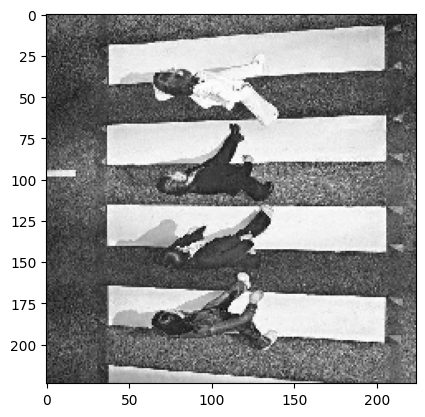

image loaded successfully!


In [9]:
original = load_img(files[-1], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [10]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the RESNET model
processed_image = preprocess_input(image_batch.copy())


image batch size (1, 224, 224, 3)


In [11]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 10s 10s/step
features successfully extracted!
number of image features: 100352


array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [13]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

7/7 [==============================] - 3s 307ms/step
features successfully extracted!


(221, 100352)

#**Cosine Similarity**

In [14]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

print(cosSimilarities)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

[[1.0000001  0.63424987 0.8189713  ... 0.7934871  0.6481648  0.7443843 ]
 [0.63424987 1.0000005  0.629949   ... 0.5821594  0.47384492 0.564471  ]
 [0.8189713  0.629949   1.0000002  ... 0.77489585 0.7128559  0.8538184 ]
 ...
 [0.7934871  0.5821594  0.77489585 ... 1.0000001  0.66078347 0.7463415 ]
 [0.6481648  0.47384492 0.7128559  ... 0.66078347 1.0000008  0.6481356 ]
 [0.7443843  0.564471   0.8538184  ... 0.7463415  0.6481356  1.0000004 ]]


,/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg,...,/content/drive/MyDrive/CSE465/Dataset/mix weather/0852.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0879.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0883.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0854.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0844.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0849.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0858.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/beatles.jpg
/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,1.000000,0.634250,0.818971,0.469340,0.591286,0.461070,0.727589,0.651018,0.587215,0.382385,...,0.673737,0.667640,0.549817,0.613244,0.802605,0.500507,0.660254,0.793487,0.648165,0.744384
/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,0.634250,1.000000,0.629949,0.604181,0.668752,0.517501,0.578406,0.648160,0.409100,0.797820,...,0.590017,0.488037,0.448470,0.365839,0.625719,0.412270,0.764624,0.582159,0.473845,0.564471
/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,0.818971,0.629949,1.000000,0.527788,0.662189,0.591981,0.850684,0.767803,0.750269,0.478196,...,0.720029,0.812997,0.621177,0.686894,0.763709,0.669966,0.587418,0.774896,0.712856,0.853818
/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,0.469340,0.604181,0.527788,1.000000,0.779912,0.393015,0.493110,0.696181,0.444671,0.551662,...,0.672236,0.391386,0.322958,0.313892,0.330088,0.322965,0.652628,0.405537,0.416676,0.440565
/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,0.591286,0.668752,0.662189,0.779912,1.000000,0.589520,0.640029,0.790837,0.485989,0.533363,...,0.677785,0.551112,0.490762,0.344770,0.584403,0.493593,0.631400,0.554003,0.483963,0.502651


In [15]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


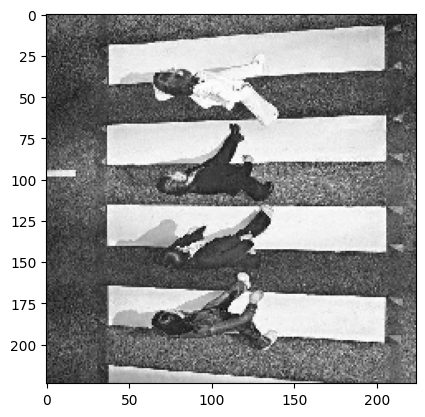

-----------------------------------------------------------------------
most similar products:


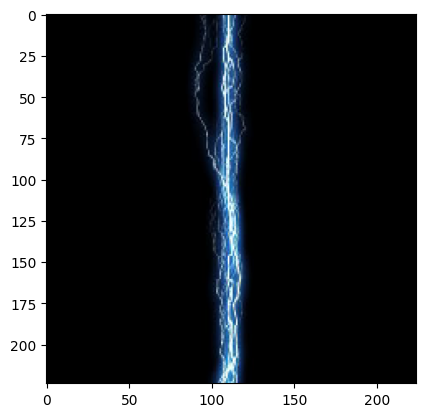

similarity score :  0.8855341


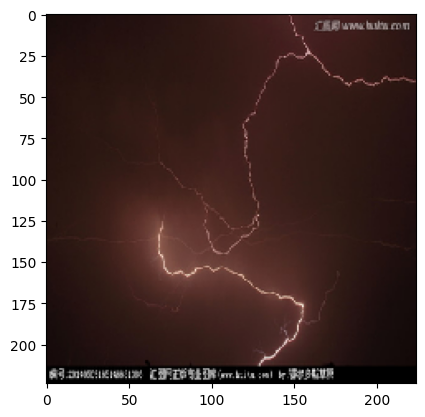

similarity score :  0.85858583


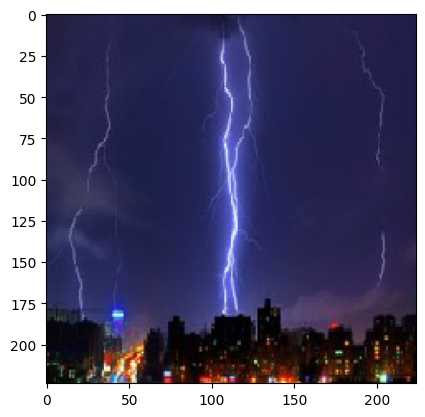

similarity score :  0.8538184


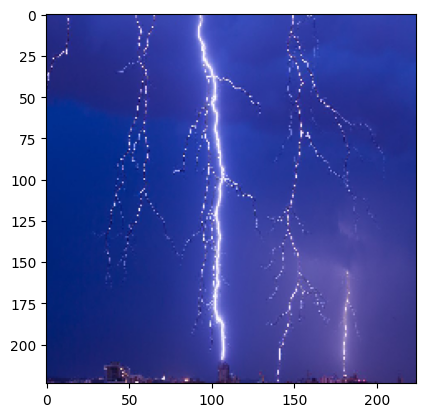

similarity score :  0.8444119


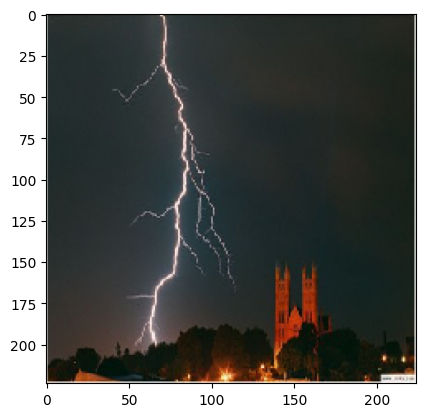

similarity score :  0.84267956


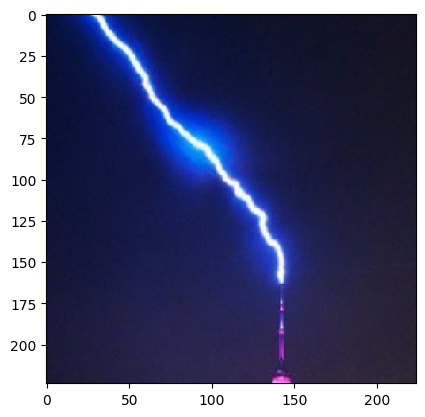

similarity score :  0.8406054


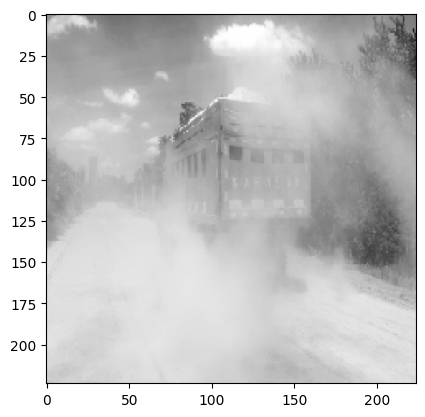

similarity score :  0.8377871


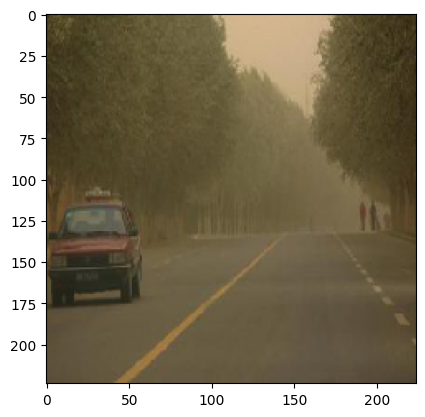

similarity score :  0.8314236


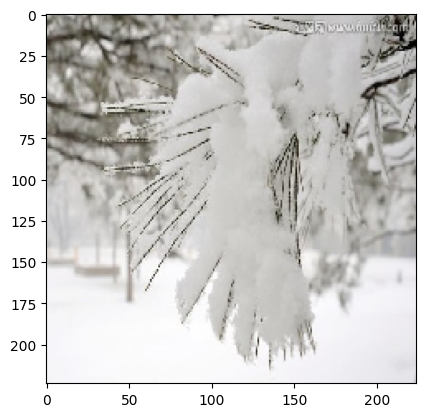

similarity score :  0.8306578


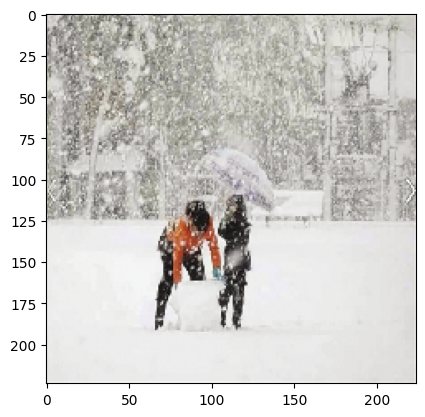

similarity score :  0.8296086


In [16]:
retrieve_most_similar_products(files[-1])

#**Euclidean distance**

In [17]:
from sklearn.metrics.pairwise import pairwise_distances

# compute Euclidean distances between image features
euclidean_distances = pairwise_distances(imgs_features, metric='euclidean')

print(euclidean_distances)
euclidean_distances_df = pd.DataFrame(euclidean_distances, columns=files, index=files)
euclidean_distances_df.head()

[[     0.    227137.52  149916.98  ... 206345.97  224399.97  213619.06 ]
 [227137.52       0.    156141.55  ...  57968.766  56677.703  55737.41 ]
 [149916.98  156141.55       0.    ... 137433.36  148900.86  133446.73 ]
 ...
 [206345.97   57968.766 137433.36  ...      0.     53372.863  47928.64 ]
 [224399.97   56677.703 148900.86  ...  53372.863      0.     51349.113]
 [213619.06   55737.41  133446.73  ...  47928.64   51349.113      0.   ]]


,/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg,...,/content/drive/MyDrive/CSE465/Dataset/mix weather/0852.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0879.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0883.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0854.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0844.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0849.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0858.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/beatles.jpg
/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,0.000000,227137.515625,149916.984375,238724.640625,217280.031250,231774.359375,217231.875000,200445.328125,208368.390625,245382.156250,...,219564.015625,226626.000000,241759.093750,235686.500000,201467.890625,241012.531250,205908.593750,206345.968750,224399.968750,213619.062500
/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,227137.515625,0.000000,156141.546875,44939.019531,65028.945312,67904.359375,52518.792969,183047.093750,147201.593750,32557.435547,...,53491.332031,52491.585938,48033.937500,52949.675781,59389.660156,50599.578125,67091.687500,57968.765625,56677.703125,55737.410156
/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,149916.984375,156141.546875,0.000000,164229.687500,142258.140625,151600.921875,136523.484375,138011.687500,123800.000000,169546.843750,...,145350.390625,146111.796875,166921.953125,160319.703125,135386.015625,162013.312500,149315.000000,137433.359375,148900.859375,133446.734375
/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,238724.640625,44939.019531,164229.687500,0.000000,58484.167969,73483.796875,55239.433594,183425.296875,146036.375000,40734.980469,...,47038.218750,53795.511719,47009.867188,50375.402344,74821.843750,49255.949219,76487.906250,66290.250000,56837.410156,60689.507812
/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,217280.031250,65028.945312,142258.140625,58484.167969,0.000000,75255.390625,67150.835938,153617.671875,140769.703125,74366.453125,...,64247.425781,72798.656250,76976.718750,82249.968750,74981.554688,76129.882812,80297.335938,75637.718750,77742.445312,78121.039062


In [18]:
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = euclidean_distances_df[given_img].sort_values()[1:nb_closest_images+1].index
    closest_imgs_scores = euclidean_distances_df[given_img].sort_values()[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("Euclidian distance : ",closest_imgs_scores[i])

In [19]:
retrieve_most_similar_products(files[-1])

Output hidden; open in https://colab.research.google.com to view.